In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from torch import cuda
from lib.dataset_utils import *
from lib.plot_utils import *
from lib.models import *
from lib.cross_validation import *
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'deprecated'

In [2]:
#TODO provRE contraction mapping
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}


In [6]:
# Defining some key variables that will be used later on in the training
DATASET_NAME = DatasetEnum.GoEmotionsCleaned
CHECKPOINT_DIR = './checkpoints/'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + 'bert_model_cleaned_NoReg.pth'
MINIBATCH_SIZE = 16
EPOCHS = 4
LAMBDA = 0
LEARNING_RATE = 5e-05
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET_NAME)
MAX_LEN = compute_max_tokens([train_df, val_df, test_df], BertTokenizer.from_pretrained('bert-base-cased'))
LABEL_COLS = train_df.columns[1:].tolist()

NameError: name 'DatasetEnum' is not defined

In [31]:
test_df.head()

,text,admiration,amusement,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,...,sadness,surprise,neutral,annoyance,approval,caring,confusion,curiosity,desire,disappointment
0,I’m really sorry about your situation :( Altho...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,It's wonderful because it's awful. At not with.,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Kings fan here, good luck to you guys! Will be...",0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"I didn't know that, thank you for teaching me ...",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,They got bored from haunting earth for thousan...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [2]:
# tuning implicitly done in score calculation :)
def accuracy(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, accuracy_score)
    return best_res

def jaccard(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, jaccard_score, {'average': 'macro', 'zero_division': 0})
    return best_res

def jaccard_samples(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, jaccard_score, {'average': 'samples', 'zero_division': 0})
    return best_res

def f1(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, f1_score, {'average': 'macro', 'zero_division': 0})
    return best_res

def f1_micro(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, f1_score, {'average': 'micro', 'zero_division': 0})
    return best_res
'''
weaker accuracy, each prediction is considered correct if its maximum probability class is one of the true classes
'''
def membership_score(y_true, y_pred):
    n_correct = 0
    for t_pattern, p_pattern in zip(y_true, y_pred):
        n_correct += t_pattern[np.argmax(p_pattern)] == 1
    return n_correct / len(y_true)

In [4]:
# model parameters
PARAMS = {'tokenizer_max_len':MAX_LEN, 
          'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':len(LABEL_COLS)}
# scores dictionary
SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}
# creating the 
# we set a seed ti get the sane weight initializzazion for the data prep validation
seed_val = 14
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model = Bert(SCORES,
                PARAMS)                 

NameError: name 'MAX_LEN' is not defined

In [16]:
model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

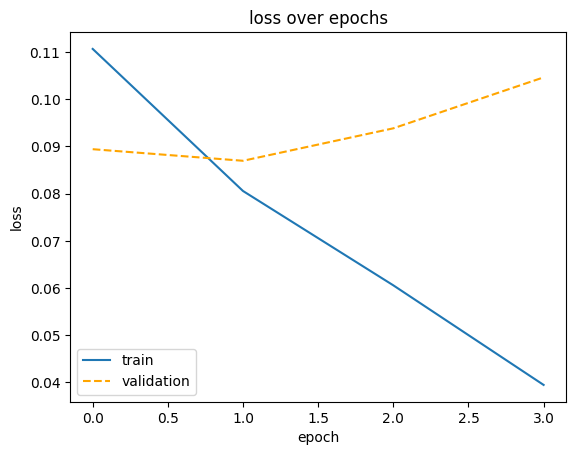

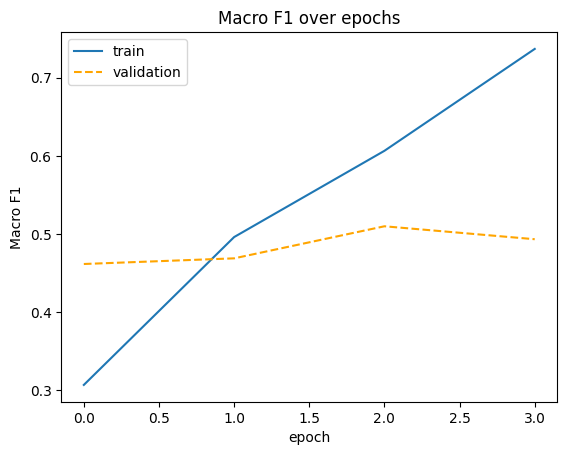

In [17]:
def plot_learning_curves(tr_loss, val_loss, score_name = 'loss'):
    plt.plot(tr_loss, label='train')
    plt.plot(val_loss, label='validation', color='orange', linestyle='--')
    plt.xlabel('epoch')
    plt.ylabel(score_name)
    plt.legend()
    plt.title(f'{score_name} over epochs')
    plt.show()

# plot learning curves
tr_scores, val_scores = model.get_train_scores(), model.get_val_scores()
tr_loss, val_loss = model.get_train_loss(), model.get_val_loss()

plot_learning_curves(tr_loss, val_loss)
plot_learning_curves(tr_scores['f1_macro'], val_scores['f1_macro'], 'Macro F1')

In [18]:
out = model.predict(test_df)
target = test_df.iloc[:, 1:].values

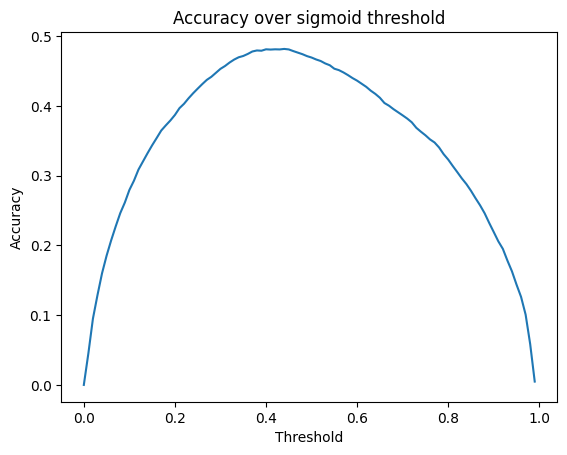

Best threshold: 0.44
Best Accuracy: 0.4818500092131933


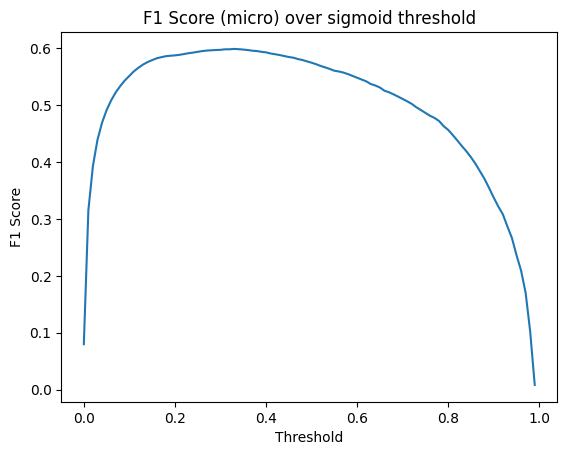

Best threshold: 0.33
Best F1 Score (micro): 0.5982227864170104


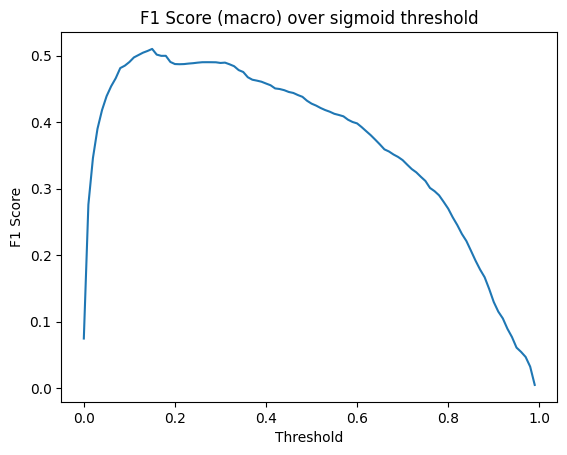

Best threshold: 0.15
Best F1 Score (macro): 0.5102663111629383


In [19]:
plot_threshold_tuning(target, out, plot=True)
plot_threshold_tuning(target, out, plot=True, metric_params={'average':'micro', 'zero_division':0}, metric_fun=f1_score, metric_name='F1 Score')
plot_threshold_tuning(target, out, plot=True, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score, metric_name='F1 Score')

In [4]:
# get best threshold
thresh, _ = tune_sigmoid_threshold(target, out, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)

NameError: name 'target' is not defined

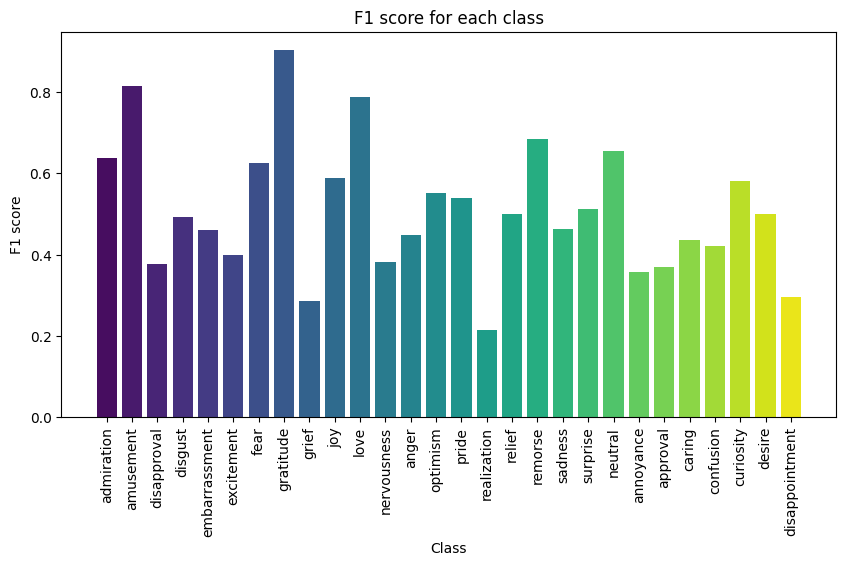

In [21]:
# bar plot over classes

best_out = (out > thresh).astype(int)
plot_score_barplot(target, best_out, LABEL_COLS)

## Goemotions:NoDataCleaning
We try to validate our datacleaning process training a bert model with vanilla tr-set

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

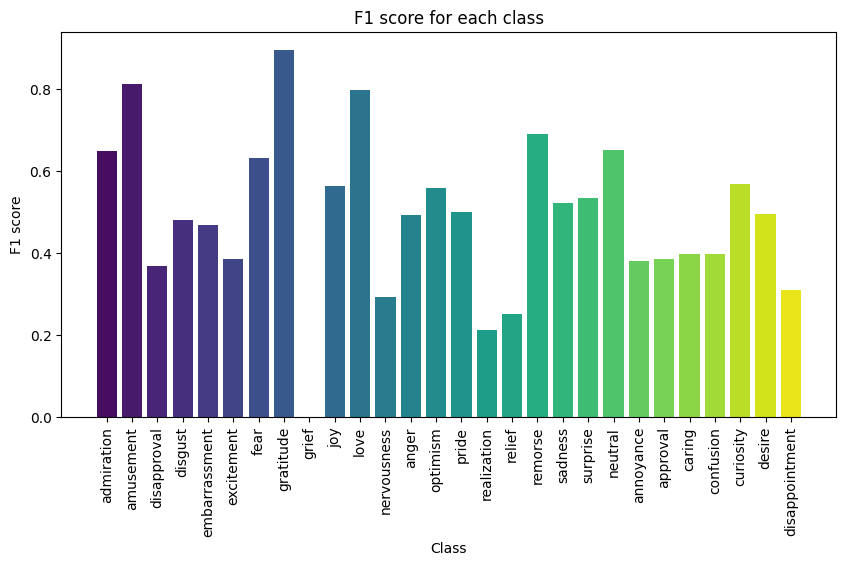

In [7]:
train_df, val_df, test_df = load_goemotions(k_hot_encode=True)
CHECKPOINT_MODEL_FILE_UNCLEANED=CHECKPOINT_DIR + 'bert_model_Uncleaned_NoReg.pth'

# creating the model with the same seed as the cleaned version
seed_val = 14
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model_uncleaned = Bert(SCORES,
                PARAMS)    
model_uncleaned.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE_UNCLEANED,checkpoint_score="f1_macro",checkpoint_score_maximize=True)
out_uncleaned = model_uncleaned.predict(test_df)
target_uncleaned = test_df.iloc[:, 1:].values
thresh_uncleaned, _ = tune_sigmoid_threshold(target_uncleaned, out_uncleaned, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
best_out_uncleaned = (out_uncleaned > thresh_uncleaned).astype(int)
plot_score_barplot(target_uncleaned, best_out_uncleaned, LABEL_COLS)

Now we can compare the graphical results of the obtained models

In [8]:
_,_, test_df_uncleaned = load_goemotions(k_hot_encode=True)
_,_, test_df = load_dataset(DatasetEnum.GoEmotionsCleaned)

PARAMS = {'tokenizer_max_len':MAX_LEN, 
          'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':28
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}
CHECKPOINT_MODEL_FILE_UNCLEANED=CHECKPOINT_DIR + 'bert_model_Uncleaned_NoReg.pth'
CHECKPOINT_MODEL_FILE_CLEANED=CHECKPOINT_DIR + 'bert_model_cleaned_NoReg.pth'

# creating the model uncleaned
model_uncleaned = Bert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE_UNCLEANED)    
out_uncleaned = model_uncleaned.predict(test_df_uncleaned)
target_uncleaned = test_df_uncleaned.iloc[:, 1:].values
thresh_uncleaned, _ = tune_sigmoid_threshold(target_uncleaned, out_uncleaned, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
best_out_uncleaned = (out_uncleaned > thresh_uncleaned).astype(int)

# creating the model cleaned
model_cleaned = Bert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE_CLEANED)    
out_cleaned = model_cleaned.predict(test_df)
target_cleaned = test_df.iloc[:, 1:].values
thresh_cleaned, _ = tune_sigmoid_threshold(target_cleaned, out_cleaned, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
best_out_cleaned = (out_cleaned > thresh_cleaned).astype(int)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerN

C:\Users\gdema\AppData\Local\Temp\ipykernel_5524\2501826934.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(),


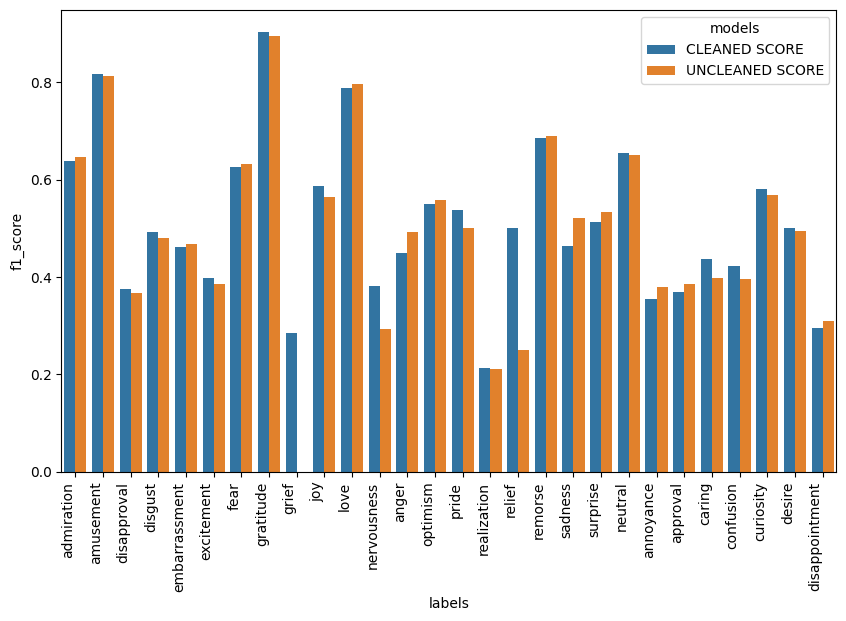

cleaned mean = 0.5102663111629383
uncleaned mean = 0.48867660291253995


In [9]:

cleaned_score = f1_score(target_cleaned, best_out_cleaned,average=None)
uncleaned_score = f1_score(target_uncleaned, best_out_uncleaned,average=None)

# we create a dataframe with for each label the f1 score for both the models
results_df=pd.DataFrame(zip(LABEL_COLS,cleaned_score,uncleaned_score),columns=["labels","CLEANED SCORE","UNCLEANED SCORE"])
results_df = pd.melt(results_df, id_vars="labels", var_name="models", value_name="f1_score")
plt.figure(figsize=(10, 6))
barplot=sns.barplot(x="labels", hue="models", y="f1_score", data=results_df)
barplot.set_xticklabels(barplot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

print(f"cleaned mean = {np.mean(cleaned_score)}\nuncleaned mean = {np.mean(uncleaned_score)}")

Dai risultati la data preparation sembrerebbe valida, si gha un buon miglioramento per le emozioni *grief* e *relief*

# GO Emotions: 6 emotions
We can try to map the 27 emtions to Ekman standard and finetune a new model. <br>
We compare mapping first the dataset and then training the model with training the model and mapping the results to get the better alternative

## Post-mapping
Using the model already fine-tuned, we map the results.


In [10]:
train_df, val_df, test_df = load_goemotions(DatasetEnum.GoEmotionsCleaned)
CHECKPOINT_MODEL_FILE_CLEANED=CHECKPOINT_DIR + 'bert_model_cleaned_NoReg.pth'
# creating the model with the same seed as the cleaned version
model_cleaned = Bert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE_CLEANED)    
out_uncleaned = model_uncleaned.predict(test_df)

#first we map the test set
test_df = goemotions_apply_emotion_mapping(test_df)



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NameError: name 'goemotions_apply_emotion_mapping' is not defined